<h1> Inference of cell-cell interactions that are related to a specific signal (circadian rhythm)</h1>
<h3>Applying CellPhoneDB algorithm over our enhanced data, for uncovering cell-cell interactions that are related to the circadian rhythm.</h3>


In [1]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import pandas as pd
from algorithms import *
from data_gen import *
from spectrum_gen import *
from visualizations import *
from analysis import *

import squidpy as sq


/Users/jonathankarin/.conda/envs/project/lib/python3.8/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
/Users/jonathankarin/.conda/envs/project/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
adata =  read_all_scn()
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)




In [4]:
def find_diff_matrix(cluster1,cluster2,comm_array_raw,comm_array_en):
    '''Find the interactions whose score increased at least two-fold following scPrisma's enhancement (and statistically significant)'''
    df_raw , df_en = find_lr_df(cluster1,cluster2,comm_array_raw,comm_array_en)
    df_en_sorted = retain_high_scores_en(df_raw , df_en)
    return df_en_sorted

def find_lr_df(cluster1,cluster2,comm_array_raw,comm_array_en):
    '''Transfer cellphonedb output to dataframe'''
    sf = ((((comm_array_raw['means'])[cluster1])[cluster2]))
    sf_p = ((((comm_array_raw['pvalues'])[cluster1])[cluster2]))
    df1 = pd.DataFrame(data=sf.index, columns=['source'])
    df2 = pd.DataFrame(data=sf.values, columns=['values'])
    df3 = pd.DataFrame(data=sf_p.values, columns=['pvalues'])
    df = pd.merge(df1, df2, left_index=True, right_index=True)
    df = pd.merge(df, df3, left_index=True, right_index=True)
    df[['source', 'target']] = pd.DataFrame(df['source'].tolist(), index=df.index)
    df = df.dropna()
    df_raw = df
    sf = ((((comm_array_en['means'])[cluster1])[cluster2]))
    sf_p = ((((comm_array_en['pvalues'])[cluster1])[cluster2]))
    df1 = pd.DataFrame(data=sf.index, columns=['source'])
    df2 = pd.DataFrame(data=sf.values, columns=['values'])
    df3 = pd.DataFrame(data=sf_p.values, columns=['pvalues'])
    df = pd.merge(df1, df2, left_index=True, right_index=True)
    df = pd.merge(df, df3, left_index=True, right_index=True)
    df[['source', 'target']] = pd.DataFrame(df['source'].tolist(), index=df.index)
    df = df.dropna()
    df_en = df
    return df_raw , df_en

def retain_high_scores_en(df_raw , df_en):
    '''Retain only positive scores which increased at least two-fold following scPrisma's enhancement'''
    df_en = df_en[(df_en['values'] > 0) ]
    df_en = df_en.sort_values(by='values', ascending=False)
    for index, row in df_en.iterrows():
        df_raw_tmp = df_raw[(df_raw['source'] ==row['source']) ]
        if len(df_raw_tmp.index)==0:
            continue
        df_raw_tmp = df_raw_tmp[( df_raw_tmp['target']==row['target'])]
        if len(df_raw_tmp.index)==0:
            continue
        if row['values'] <  2*float(df_raw_tmp['values']):#2* float(df_raw_tmp['values']):
            df_en.drop(index, axis=0, inplace=True)
    return df_en

def count_ligand_receptor(df,ligands_list,receptors_list):
    '''Count number of interactions that contains genes from ligands/receptor lists'''
    count_ligand=0
    for ligand in ligands_list:
        count_ligand+=df[df['source']==ligand].shape[0]
    count_receptor=0
    for receptor in receptors_list:
        count_receptor+=df[df['target']==receptor].shape[0]
    return count_ligand , count_receptor

def preproc_for_lr(adata):
    '''The workflow was applied for each cell type separately, this function merges the processed data'''
    cluster_list = [
        'Ependymal',
        'NG2',
        'Endothelial',
        'Astrocytes',
        'Microglia',
        'Tanycytes',
        'Oligodendrocytes',
        'Neurons2']
    adata.X = adata.X *0
    adata_en = adata.copy()
    barcodes = []
    clusters = []
    adata.obs['cluster'] =1
    a = np.ones((10,10))
    for i , cluster in enumerate(cluster_list):
        adata_tmp_raw = sc.read("SCN/" + cluster+"_raw" +".h5ad")
        adata_tmp_en = sc.read("SCN/" + cluster+"_en" +".h5ad")
        for cluster in cluster_list:   
            adata_tmp_raw = sc.read("SCN/" + cluster+"_raw" +".h5ad")
            adata_tmp_en = sc.read("SCN/" + cluster+"_en" +".h5ad")
            barcodes += list(adata_tmp_raw.obs_names)
            clusters += [cluster]* len(list(adata_tmp_raw.obs_names))
            for ob in adata_tmp_raw.obs_names:
                    adata[ob,adata_tmp_raw[ob,:].var_names].X = adata_tmp_raw[ob,adata_tmp_raw[ob,:].var_names].X
                    adata_en[ob,adata_tmp_raw[ob,:].var_names].X = adata_tmp_en[ob,adata_tmp_raw[ob,:].var_names].X
            adata.obs.loc[adata_tmp_raw.obs_names, 'cluster'] = cluster
            adata_en.obs.loc[adata_tmp_raw.obs_names, 'cluster'] = cluster
            #https://stackoverflow.com/questions/63272201/how-to-add-an-observation-category-on-scanpy-based-on-another-observation
        adata = adata[barcodes]
        adata_en = adata_en[barcodes]
        adata.obs['cluster']= adata.obs['cluster'].astype('category')
        adata_en.obs['cluster']= adata_en.obs['cluster'].astype('category')
        return adata , adata_en
pdata, pdata_en = preproc_for_lr(adata) 

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [6]:
sc.pp.normalize_per_cell(pdata_en, counts_per_cell_after=1e4)
sc.pp.log1p(pdata_en)
pdata_en_norm = pdata_en

Proccess each time point separately

In [7]:

res_raw = sq.gr.ligrec(
        pdata,
        n_perms=1000,
        cluster_key="cluster",
        copy=True,
        use_raw=False,
        transmitter_params={"categories": "ligand"},
        receiver_params={"categories": "receptor"},
    )

res_en = sq.gr.ligrec(
        pdata_en,
        n_perms=1000,
        cluster_key="cluster",
        copy=True,
        use_raw=False,
        transmitter_params={"categories": "ligand"},
        receiver_params={"categories": "receptor"},
    )

pdata_02 = (pdata[pdata.obs['CT'].isin(['02'])])
pdata_en_02 = (pdata_en_norm[pdata_en_norm.obs['CT'].isin(['02'])])
res_raw_02 = sq.gr.ligrec(
        pdata_02,
        n_perms=1000,
        cluster_key="cluster",
        copy=True,
        use_raw=False,
        transmitter_params={"categories": "ligand"},
        receiver_params={"categories": "receptor"},
    )

res_en_02 = sq.gr.ligrec(
        pdata_en_02,
        n_perms=1000,
        cluster_key="cluster",
        copy=True,
        use_raw=False,
        transmitter_params={"categories": "ligand"},
        receiver_params={"categories": "receptor"},
    )

pdata_06 = (pdata[pdata.obs['CT'].isin(['06'])])
pdata_en_06= (pdata_en_norm[pdata_en_norm.obs['CT'].isin(['06'])])
res_raw_06 = sq.gr.ligrec(
        pdata_06,
        n_perms=1000,
        cluster_key="cluster",
        copy=True,
        use_raw=False,
        transmitter_params={"categories": "ligand"},
        receiver_params={"categories": "receptor"},
    )

res_en_06 = sq.gr.ligrec(
        pdata_en_06,
        n_perms=1000,
        cluster_key="cluster",
        copy=True,
        use_raw=False,
        transmitter_params={"categories": "ligand"},
        receiver_params={"categories": "receptor"},
    )


pdata_10 = (pdata[pdata.obs['CT'].isin(['10'])])
pdata_en_10= (pdata_en_norm[pdata_en_norm.obs['CT'].isin(['10'])])
res_raw_10 = sq.gr.ligrec(
        pdata_10,
        n_perms=1000,
        cluster_key="cluster",
        copy=True,
        use_raw=False,
        transmitter_params={"categories": "ligand"},
        receiver_params={"categories": "receptor"},
    )

res_en_10 = sq.gr.ligrec(
        pdata_en_10,
        n_perms=1000,
        cluster_key="cluster",
        copy=True,
        use_raw=False,
        transmitter_params={"categories": "ligand"},
        receiver_params={"categories": "receptor"},
    )

pdata_14 = (pdata[pdata.obs['CT'].isin(['14'])])
pdata_en_14= (pdata_en_norm[pdata_en_norm.obs['CT'].isin(['14'])])
res_raw_14 = sq.gr.ligrec(
        pdata_14,
        n_perms=1000,
        cluster_key="cluster",
        copy=True,
        use_raw=False,
        transmitter_params={"categories": "ligand"},
        receiver_params={"categories": "receptor"},
    )

res_en_14 = sq.gr.ligrec(
        pdata_en_14,
        n_perms=1000,
        cluster_key="cluster",
        copy=True,
        use_raw=False,
        transmitter_params={"categories": "ligand"},
        receiver_params={"categories": "receptor"},
    )

pdata_18 = (pdata[pdata.obs['CT'].isin(['18'])])
pdata_en_18= (pdata_en_norm[pdata_en_norm.obs['CT'].isin(['18'])])
res_raw_18 = sq.gr.ligrec(
        pdata_18,
        n_perms=1000,
        cluster_key="cluster",
        copy=True,
        use_raw=False,
        transmitter_params={"categories": "ligand"},
        receiver_params={"categories": "receptor"},
    )

res_en_18 = sq.gr.ligrec(
        pdata_en_18,
        n_perms=1000,
        cluster_key="cluster",
        copy=True,
        use_raw=False,
        transmitter_params={"categories": "ligand"},
        receiver_params={"categories": "receptor"},
    )

pdata_22 = (pdata[pdata.obs['CT'].isin(['22'])])
pdata_en_22= (pdata_en_norm[pdata_en_norm.obs['CT'].isin(['22'])])
res_raw_22 = sq.gr.ligrec(
        pdata_22,
        n_perms=1000,
        cluster_key="cluster",
        copy=True,
        use_raw=False,
        transmitter_params={"categories": "ligand"},
        receiver_params={"categories": "receptor"},
    )

res_en_22 = sq.gr.ligrec(
        pdata_en_22,
        n_perms=1000,
        cluster_key="cluster",
        copy=True,
        use_raw=False,
        transmitter_params={"categories": "ligand"},
        receiver_params={"categories": "receptor"},
    )
def get_lr_score(res, cell_type_source,cell_type_target,ligand, receptor):
    try:
        return ((((res['means'])[cell_type_source])[cell_type_target])[ligand])[receptor]
    except:
        return 0
pdata_02.write("adata_for_lr_raw_02.h5ad")
pdata_en_02.write("adata_for_lr_en_02.h5ad")
pdata_06.write("adata_for_lr_raw_06.h5ad")
pdata_en_06.write("adata_for_lr_en_06.h5ad")
pdata_10.write("adata_for_lr_raw_10.h5ad")
pdata_en_10.write("adata_for_lr_en_10.h5ad")
pdata_14.write("adata_for_lr_raw_14.h5ad")
pdata_en_14.write("adata_for_lr_en_14.h5ad")
pdata_18.write("adata_for_lr_raw_18.h5ad")
pdata_en_18.write("adata_for_lr_en_18.h5ad")
pdata_22.write("adata_for_lr_raw_22.h5ad")
pdata_en_22.write("adata_for_lr_en_22.h5ad")




  0%|          | 0/1000 [00:00<?, ?permutation/s]

  0%|          | 0/1000 [00:00<?, ?permutation/s]

  0%|          | 0/1000 [00:00<?, ?permutation/s]

  0%|          | 0/1000 [00:00<?, ?permutation/s]

  0%|          | 0/1000 [00:00<?, ?permutation/s]

  0%|          | 0/1000 [00:00<?, ?permutation/s]

  0%|          | 0/1000 [00:00<?, ?permutation/s]

  0%|          | 0/1000 [00:00<?, ?permutation/s]

  0%|          | 0/1000 [00:00<?, ?permutation/s]

  0%|          | 0/1000 [00:00<?, ?permutation/s]

  0%|          | 0/1000 [00:00<?, ?permutation/s]

  0%|          | 0/1000 [00:00<?, ?permutation/s]

  0%|          | 0/1000 [00:00<?, ?permutation/s]

  0%|          | 0/1000 [00:00<?, ?permutation/s]

/Users/jonathankarin/.conda/envs/project/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/Users/jonathankarin/.conda/envs/project/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'CT' as categorical
/Users/jonathankarin/.conda/envs/project/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/Users/jonathank

<h3>Create a data frame that contains interactions whose score increased at least two-fold following scPrisma's enhancement (and is statistically significant).</h3>

In [8]:
res_raw_list = [res_raw_02,res_raw_06,res_raw_10,res_raw_14,res_raw_18,res_raw_22]
res_en_list = [res_en_02,res_raw_06,res_en_10,res_en_14,res_en_18,res_en_22]
cluster_list = [
    'Ependymal',
    'NG2',
    'Endothelial',
    'Astrocytes',
    'Microglia',
    'Oligodendrocytes',
    'Neurons2']
first=True
for i in range(6):
    for cluster1 in cluster_list:
        for cluster2 in cluster_list:
            if cluster1==cluster2:
                continue
            df = find_diff_matrix(cluster1,cluster2,res_raw_list[i],res_en_list[i])
            if len(df.index)==0:
                continue
            df['source cell type']= cluster1
            df['target cell type']= cluster2
            df['CT']=i*4 +2
            #print("Cell type source: " + cluster1 + " cell type target: " + cluster2 + " circadian time: " +str(i*4 +2))
            #print(df)
            if first:
                two_fold_output_df = df
                first=False
            else:
                two_fold_output_df = pd.concat([two_fold_output_df, df])
two_fold_output_df

<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:35: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[0, nan]'. Picking the first and converting the rest.
  for index, row in df_en.iterrows():
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:35: Perfor

<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:35: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[0, nan]'. Picking the first and converting the rest.
  for index, row in df_en.iterrows():
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:35: Perfor

<ipython-input-4-1a6f1d43df55>:35: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[0, nan]'. Picking the first and converting the rest.
  for index, row in df_en.iterrows():
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:35: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[0, nan]'. Picking the first and converting the rest.
  for index, row in df_en.iterrows():
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df

<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:35: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[0, nan]'. Picking the first and converting the rest.
  for index, row in df_en.iterrows():
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:35: Perfor

<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:35: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[0, nan]'. Picking the first and converting the rest.
  for index, row in df_en.iterrows():
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:35: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[0, nan]'. Picking the first and converting the rest.
  for index, row in df_en.iterrows():
<ipython-input-4-1a6f1d43df

<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:35: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[0, nan]'. Picking the first and converting the rest.
  for index, row in df_en.iterrows():
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:35: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[0, nan]'. Picking the first and converting the rest.
  for index, row in df_en.iterrows():
<ipython-input-4-1a6f1d43df

<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:35: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[0, nan]'. Picking the first and converting the rest.
  for index, row in df_en.iterrows():
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:35: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[0, nan]'. Picking the first and converting the rest.
  for index, row in df_en.iterrows():
<ipython-input-4-1a6f1d43df

<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:35: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[0, nan]'. Picking the first and converting the rest.
  for index, row in df_en.iterrows():
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:35: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[0, nan]'. Picking the first and converting the rest.
  for index, row in df_en.iterrows():
<ipython-input-4-1a6f1d43df

<ipython-input-4-1a6f1d43df55>:35: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[0, nan]'. Picking the first and converting the rest.
  for index, row in df_en.iterrows():
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:35: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[0, nan]'. Picking the first and converting the rest.
  for index, row in df_en.iterrows():
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df

<ipython-input-4-1a6f1d43df55>:35: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[0, nan]'. Picking the first and converting the rest.
  for index, row in df_en.iterrows():
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:35: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[0, nan]'. Picking the first and converting the rest.
  for index, row in df_en.iterrows():
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df

<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:35: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[0, nan]'. Picking the first and converting the rest.
  for index, row in df_en.iterrows():
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:35: Perfor

<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:35: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[0, nan]'. Picking the first and converting the rest.
  for index, row in df_en.iterrows():
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:35: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[0, nan]'. Picking the first and converting the rest.
  for index, row in df_en.iterrows():
<ipython-input-4-1a6f1d43df

<ipython-input-4-1a6f1d43df55>:35: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[0, nan]'. Picking the first and converting the rest.
  for index, row in df_en.iterrows():
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:35: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[0, nan]'. Picking the first and converting the rest.
  for index, row in df_en.iterrows():
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df

<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:35: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[0, nan]'. Picking the first and converting the rest.
  for index, row in df_en.iterrows():
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:35: Perfor

<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:35: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[0, nan]'. Picking the first and converting the rest.
  for index, row in df_en.iterrows():
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:35: Perfor

<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:35: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[0, nan]'. Picking the first and converting the rest.
  for index, row in df_en.iterrows():
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:35: Perfor

<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:35: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[0, nan]'. Picking the first and converting the rest.
  for index, row in df_en.iterrows():
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:35: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[0, nan]'. Picking the first and converting the rest.
  for index, row in df_en.iterrows():
<ipython-input-4-1a6f1d43df

,source,values,pvalues,target,source cell type,target cell type,CT
3938,ALCAM,0.498593,0.00,CHL1,Ependymal,NG2,2
974,AGT,0.223533,0.00,PRKCE,Ependymal,NG2,2
3126,ALCAM,1.448268,0.00,NRP1,Ependymal,Endothelial,2
981,PTN,0.352983,0.00,PTPRZ1,Ependymal,Endothelial,2
3309,AGT,0.209147,0.00,EDNRA,Ependymal,Endothelial,2
...,...,...,...,...,...,...,...
530,FGF14,0.173680,0.02,PIK3CA,Neurons2,Microglia,22
1245,EFNB3,0.950661,0.00,EPHB1,Neurons2,Oligodendrocytes,22
3031,CXCL12,0.392065,0.00,PLCB1,Neurons2,Oligodendrocytes,22
3032,AGT,0.188464,0.00,PLCB1,Neurons2,Oligodendrocytes,22


In [9]:
first=True
for i in range(6):
    for cluster1 in cluster_list:
        for cluster2 in cluster_list:
            if cluster1==cluster2:
                continue
            df_raw , df_en = find_lr_df(cluster1,cluster2,res_raw_list[i],res_en_list[i])
            if len(df.index)==0:
                continue
            df_raw['source cell type']= cluster1
            df_raw['target cell type']= cluster2
            df_raw['CT']=i*4 +2
            df_en['source cell type']= cluster1
            df_en['target cell type']= cluster2
            df_en['CT']=i*4 +2
            if first:
                output_df_en = df_en
                output_df_raw = df_raw
                first=False
            else:
                output_df_en = pd.concat([output_df_en, df_en])
                output_df_raw = pd.concat([output_df_raw, df_raw])
output_df_en = output_df_en[(output_df_en['values'] > 0) ]
output_df_raw = output_df_raw[(output_df_raw['values'] > 0) ]

output_df_en

<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-9-dab7facb2f93>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_en['source cell type']= cluster1
<ipython-input-9-dab7facb2f93>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-9-dab7facb2f93>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_en['source cell type']= cluster1
<ipython-input-9-dab7facb2f93>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_en['target cell type']= cluster2
<ipython-input-9-dab7facb2f93>:15: SettingWithCopyWarning: 
A value is trying to be set o

<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-9-dab7facb2f93>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_en['source cell type']= cluster1
<ipython-input-9-dab7facb2f93>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

<ipython-input-9-dab7facb2f93>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_en['target cell type']= cluster2
<ipython-input-9-dab7facb2f93>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_en['CT']=i*4 +2
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill valu

<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-9-dab7facb2f93>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_en['source cell type']= cluster1
<ipython-input-9-dab7facb2f93>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-9-dab7facb2f93>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_en['source cell type']= cluster1
<ipython-input-9-dab7facb2f93>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_en['target cell type']= cluster2
<ipython-input-9-dab7facb2f93>:15: SettingWithCopyWarning: 
A value is trying to be set o

<ipython-input-9-dab7facb2f93>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['CT']=i*4 +2
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-9-dab7facb2f93>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

<ipython-input-9-dab7facb2f93>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_en['target cell type']= cluster2
<ipython-input-9-dab7facb2f93>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_en['CT']=i*4 +2
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill valu

<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-9-dab7facb2f93>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['source cell type']= cluster1
<ipython-input-9-dab7facb2f93>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['target cell type']= cluster2
<ipython-input-9-dab7facb2f93>:12: SettingWithCopyWarning: 
A value is trying to be set

<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-9-dab7facb2f93>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['source cell type']= cluster1
<ipython-input-9-dab7facb2f93>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['target cell type']= cluster2
<ipython-input-9-dab7facb2f93>:12: SettingWithCopyWarning: 
A value is trying to be set

<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-9-dab7facb2f93>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['source cell type']= cluster1
<ipython-input-9-dab7facb2f93>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-9-dab7facb2f93>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['source cell type']= cluster1
<ipython-input-9-dab7facb2f93>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

<ipython-input-9-dab7facb2f93>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_en['target cell type']= cluster2
<ipython-input-9-dab7facb2f93>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_en['CT']=i*4 +2
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill valu

<ipython-input-9-dab7facb2f93>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['source cell type']= cluster1
<ipython-input-9-dab7facb2f93>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['target cell type']= cluster2
<ipython-input-9-dab7facb2f93>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-9-dab7facb2f93>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['source cell type']= cluster1
<ipython-input-9-dab7facb2f93>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

<ipython-input-9-dab7facb2f93>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_en['CT']=i*4 +2
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-9-dab7facb2f93>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-9-dab7facb2f93>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['source cell type']= cluster1
<ipython-input-9-dab7facb2f93>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-9-dab7facb2f93>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['source cell type']= cluster1
<ipython-input-9-dab7facb2f93>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

<ipython-input-9-dab7facb2f93>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['source cell type']= cluster1
<ipython-input-9-dab7facb2f93>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['target cell type']= cluster2
<ipython-input-9-dab7facb2f93>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

<ipython-input-9-dab7facb2f93>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['source cell type']= cluster1
<ipython-input-9-dab7facb2f93>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['target cell type']= cluster2
<ipython-input-9-dab7facb2f93>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-9-dab7facb2f93>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['source cell type']= cluster1
<ipython-input-9-dab7facb2f93>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

<ipython-input-9-dab7facb2f93>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['CT']=i*4 +2
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-9-dab7facb2f93>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-9-dab7facb2f93>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['source cell type']= cluster1
<ipython-input-9-dab7facb2f93>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['target cell type']= cluster2
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with

<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-9-dab7facb2f93>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['source cell type']= cluster1
<ipython-input-9-dab7facb2f93>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

<ipython-input-9-dab7facb2f93>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['source cell type']= cluster1
<ipython-input-9-dab7facb2f93>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['target cell type']= cluster2
<ipython-input-9-dab7facb2f93>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

<ipython-input-9-dab7facb2f93>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['CT']=i*4 +2
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-9-dab7facb2f93>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

<ipython-input-9-dab7facb2f93>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['target cell type']= cluster2
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-9-dab7facb2f93>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

<ipython-input-9-dab7facb2f93>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['target cell type']= cluster2
<ipython-input-9-dab7facb2f93>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['CT']=i*4 +2
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill va

<ipython-input-9-dab7facb2f93>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['target cell type']= cluster2
<ipython-input-9-dab7facb2f93>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['CT']=i*4 +2
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill va

<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-9-dab7facb2f93>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['source cell type']= cluster1
<ipython-input-9-dab7facb2f93>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['target cell type']= cluster2
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with

<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-9-dab7facb2f93>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['source cell type']= cluster1
<ipython-input-9-dab7facb2f93>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

<ipython-input-9-dab7facb2f93>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['target cell type']= cluster2
<ipython-input-9-dab7facb2f93>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['CT']=i*4 +2
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill va

<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-9-dab7facb2f93>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['source cell type']= cluster1
<ipython-input-9-dab7facb2f93>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['target cell type']= cluster2
<ipython-input-9-dab7facb2f93>:12: SettingWithCopyWarning: 
A value is trying to be set

<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-9-dab7facb2f93>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['source cell type']= cluster1
<ipython-input-9-dab7facb2f93>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-9-dab7facb2f93>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['source cell type']= cluster1
<ipython-input-9-dab7facb2f93>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

<ipython-input-9-dab7facb2f93>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['source cell type']= cluster1
<ipython-input-9-dab7facb2f93>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['target cell type']= cluster2
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with

<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-9-dab7facb2f93>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['source cell type']= cluster1
<ipython-input-9-dab7facb2f93>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

<ipython-input-9-dab7facb2f93>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['target cell type']= cluster2
<ipython-input-9-dab7facb2f93>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['CT']=i*4 +2
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill va

<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-9-dab7facb2f93>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['source cell type']= cluster1
<ipython-input-9-dab7facb2f93>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['target cell type']= cluster2
<ipython-input-9-dab7facb2f93>:12: SettingWithCopyWarning: 
A value is trying to be set

<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-9-dab7facb2f93>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['source cell type']= cluster1
<ipython-input-9-dab7facb2f93>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['target cell type']= cluster2
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with

<ipython-input-9-dab7facb2f93>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['source cell type']= cluster1
<ipython-input-9-dab7facb2f93>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['target cell type']= cluster2
<ipython-input-9-dab7facb2f93>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-9-dab7facb2f93>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['source cell type']= cluster1
<ipython-input-9-dab7facb2f93>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

<ipython-input-9-dab7facb2f93>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['source cell type']= cluster1
<ipython-input-9-dab7facb2f93>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['target cell type']= cluster2
<ipython-input-9-dab7facb2f93>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

<ipython-input-9-dab7facb2f93>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['CT']=i*4 +2
<ipython-input-4-1a6f1d43df55>:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-4-1a6f1d43df55>:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[False, True]'. Picking the first and converting the rest.
  df = df.dropna()
<ipython-input-9-dab7facb2f93>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

,source,values,pvalues,target,source cell type,target cell type,CT
23,CXCL12,0.206816,0.0,JAK2,Ependymal,NG2,2
40,TYK2,0.474987,0.0,PIK3R1,Ependymal,NG2,2
42,HBEGF,0.956566,0.0,PIK3R1,Ependymal,NG2,2
49,FGF7,0.596434,0.0,PIK3R1,Ependymal,NG2,2
64,CXCL12,0.490628,0.0,PIK3R1,Ependymal,NG2,2
...,...,...,...,...,...,...,...
3032,AGT,0.188464,0.0,PLCB1,Neurons2,Oligodendrocytes,22
3381,PTPN11,0.767869,0.0,MPZL1,Neurons2,Oligodendrocytes,22
3398,PTPN11,0.356859,0.0,SGMS1,Neurons2,Oligodendrocytes,22
3842,PTN,0.584430,0.0,PTPRB,Neurons2,Oligodendrocytes,22


<h3>Read rhythmic process GO:0048511 genes list</h3>

In [10]:
geo  = list(pd.read_csv("rhythmic.csv")['Symbol'])
upp_geo = []
for gene in geo:
    upp_geo.append(gene.upper())


<h3>Compute the percentage of the rhythmic process genes in the infeered interactions </h3>


In [13]:
print("Raw data (ligands)")
print(str(100 * count_ligand_receptor(output_df_raw,upp_geo,upp_geo)[0]/output_df_raw.shape[0])+ "%")
print("Raw data (receptors)")
print(str(100 * count_ligand_receptor(output_df_raw,upp_geo,upp_geo)[1]/output_df_raw.shape[0])+ "%")
print("Enhanced data (ligands)")
print(str(100* count_ligand_receptor(output_df_en,upp_geo,upp_geo)[0]/output_df_en.shape[0])+ "%")
print("Enhanced data (receptors)")
print(str(100* count_ligand_receptor(output_df_en,upp_geo,upp_geo)[1]/output_df_en.shape[0]) + "%")
print("Improovment from raw to enhancment (ligands)")
print(str(100* count_ligand_receptor(two_fold_output_df,upp_geo,upp_geo)[0]/two_fold_output_df.shape[0])+ "%")
print("Improovment from raw to enhancment (receptors)")
print(str(100* count_ligand_receptor(two_fold_output_df,upp_geo,upp_geo)[1]/two_fold_output_df.shape[0])+ "%")

Raw data (ligands)
9.68421052631579%
Raw data (receptors)
11.614035087719298%
Enhanced data (ligands)
10.801210367056965%
Enhanced data (receptors)
11.616892514142876%
Improovment from raw to enhancment (ligands)
14.285714285714286%
Improovment from raw to enhancment (receptors)
16.3265306122449%


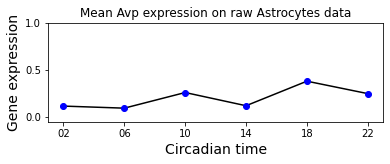

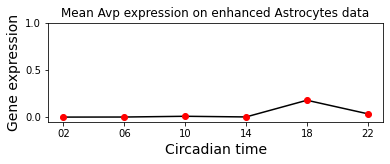

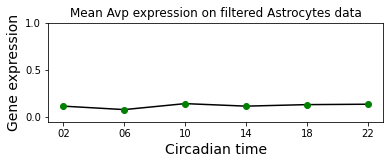

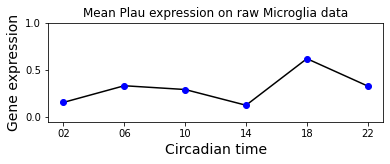

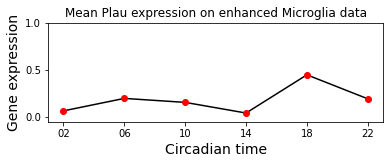

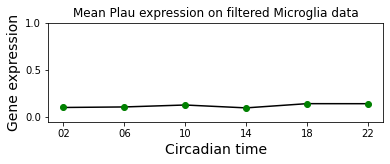

0.5011931170116771
1.0110364973660364


In [14]:
cluster1= 'Astrocytes'
cluster2 = 'Microglia'
ligand = 'Avp'
receptor = 'Plau'
plt_mean_gene(cluster1,ligand , up_lim=1)#, title=" expression- raw data")
plt_mean_gene(cluster2,receptor , up_lim=1)#, title=" expression- raw data")
print(get_lr_score(res_raw_18, cluster1,cluster2,(ligand).upper(), (receptor).upper()))
print(get_lr_score(res_en_18, cluster1,cluster2,(ligand).upper(), (receptor).upper()))


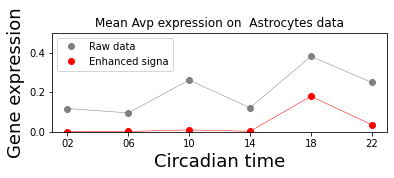

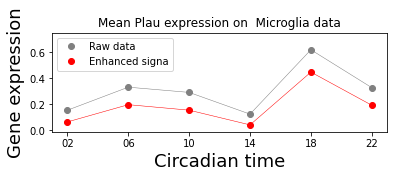

In [15]:
cluster1= 'Astrocytes'
cluster2 = 'Microglia'
ligand = 'Avp'
receptor = 'Plau'
plt_mean_gene_raw_en(cluster1,ligand,up_lim=0.5, down_lim=-0.001)
plt_mean_gene_raw_en(cluster2,receptor,up_lim=0.75, down_lim=-0.01)


In [16]:






#Save csv's
output_df_en.to_csv('interactions_enhanced_signal.csv')
output_df_raw.to_csv('interactions_raw.csv')
two_fold_output_df.to_csv('interactions_two_fold.csv')